# Implementation of dynamic circuit for Quantum Phase Estimation using Qiskit

This notebook will teach you how to construct your own dynamic circuits for Quantum Phase Estimation using Qiskit.

# Install Qiskit

Install Qiskit if you haven't. Here we are not installing the latest version of Qiskit since it has an issue with displaying circuits using matplotlib (fancy circuits) in Colab.

In [ ]:
!pip install qiskit==0.16.1

# Importing Packages

In [ ]:
from qiskit import * # No need to explain why
import matplotlib.pyplot as plt # Required to display the plot of results
import numpy as np # Need it for using pi

# The circuit

Now, we move on to main part of the notebook. In this section, we shall explain the construction of dynamic circuits for Quantum Phase Estimation of a single qubit gate, with $3$-bit precision expected. Given a method to prepare an eigenvector $| \psi \rangle$ of a one-qubit gate $U$, the circuit should be able to compute the phase of it's corresponding eigenvalue, that is, $\theta$ such that $e^{2\pi i \theta}$ is the eigenvalue associated with $| \psi \rangle$. For a $3$-bit approximation of $\theta$, the usual circuit for Quantum Phase Estimation requires $2 ^ {0} + 2 ^ {1} + 2 ^ {2} = 7$ controlled-$U$ gates and an inverse Quantum Fourier Transform circuit. The circuit is as follows:

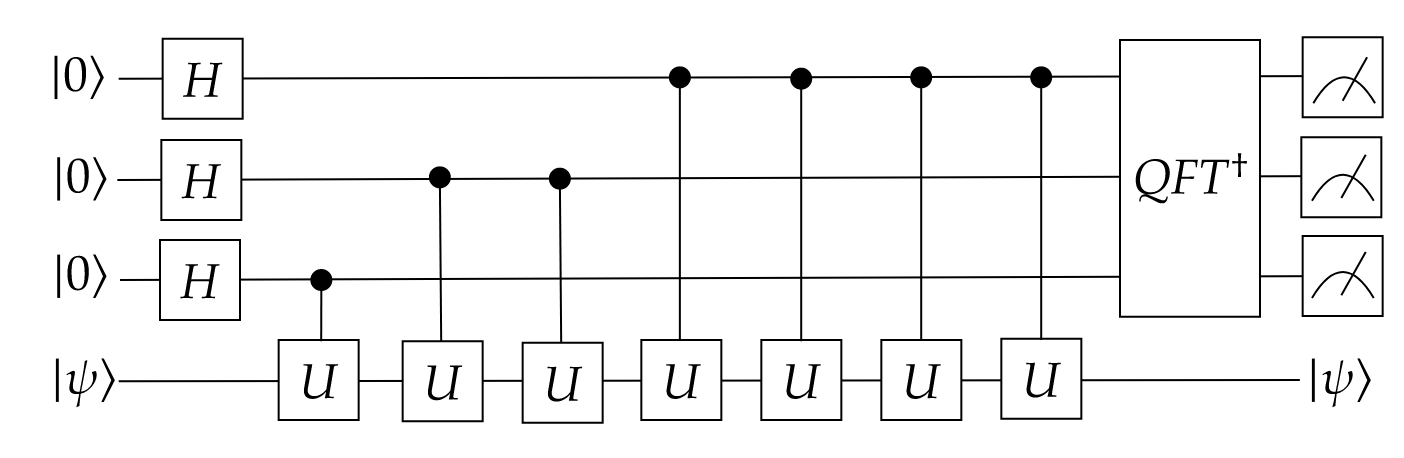

The idea of a dynamic Quantum Phase Estimation is to execute the same algorithm, but with $1$ qubit in the first register, whatever the required precision is. This is achieved by replacing the controlled operation in the inverse Quantum Fourier Transform circuit, with classical controlled quantum operations, that is, you measure the qubit and based on the result, decide to apply the quantum gate or not. The Quantum Phase Estimation circuit given above can be dynamically executed by the circuits given below

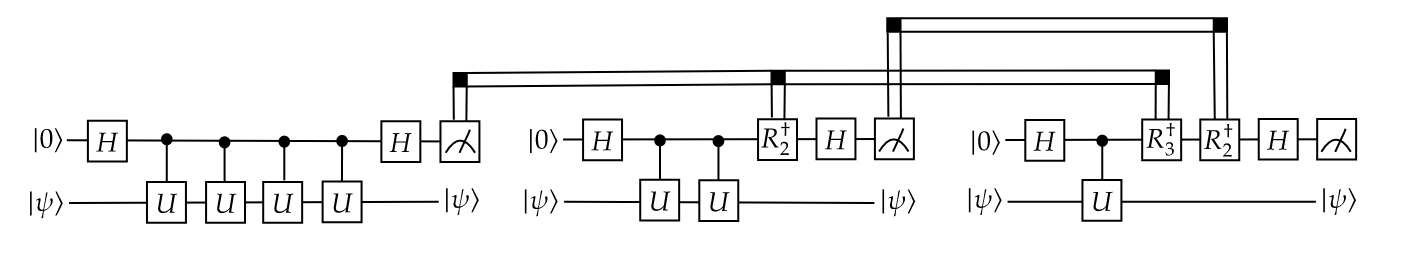

# Case 1

In this example, we are going to take $U$ to be the matrix

\begin{equation}
  U = 
  \begin{bmatrix}
    1 & 0 \\
    0 & e^{\frac{\pi i}{4}}
  \end{bmatrix}
\end{equation}

This is the famed $T$ gate. Since this is a diagonal matrix, it's eigenvectors are $|0\rangle$ with eigenvalue $1$ and $|1\rangle$ with eigenvalue $e^{\frac{ \pi i}{4}}$. That means, the phase associated with the eigenvector $|1\rangle$ is $\frac{1}{8}$, and the phase associated with the eigenvector $|0\rangle$ is $0$. 

For $R_k$ gates, we can use the $U1$ gate given as 
\begin{equation}
  U1(\phi) = 
  \begin{bmatrix}
    1 & 0\\
    0 & e ^ {i \phi}
  \end{bmatrix}
\end{equation}

If we want to carry out phase estimation with this matrix, then we should be able to apply this matrix, as a gate, in a controlled manner, that is, we should be able to use the gate

\begin{equation}
  CU =
  \begin{bmatrix}
    1 & 0 & 0 & 0\\
    0 & 1 & 0 & 0\\
    0 & 0 & 1 & 0\\
    0 & 0 & 0 & e ^ {\frac{\pi i}{4}}
  \end{bmatrix}
\end{equation}
 
 This can be achieved by the controlled-$U1$ gate in Qiskit, whose form is 

 \begin{equation}
  CU1(\phi) =
  \begin{bmatrix}
    1 & 0 & 0 & 0\\
    0 & 1 & 0 & 0\\
    0 & 0 & 1 & 0\\
    0 & 0 & 0 & e ^ {i \phi}
  \end{bmatrix}
\end{equation}


## When $| \psi \rangle = |1\rangle$

In this section, we shall use our $U$ gate to compute the phase associated with it's eigenvector $|1\rangle$, dynamically. The circuit then will have the form

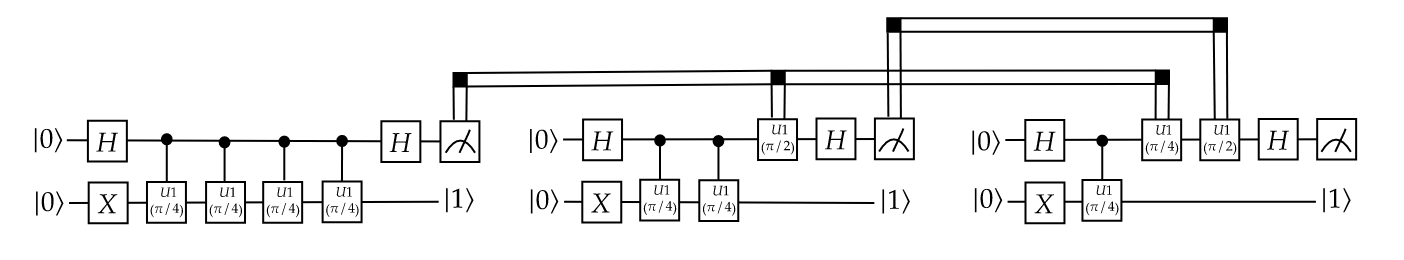

Now, let's move on to constructing the circuit using Qiskit. In our construction, the bottom qubit in the circuit diagram given above is qubit 0 and the top qubit is qubit 1.

From the cirucit diagram, we can see that we have to execute $3$ circuits, each one based on the output of the previous one. So, we shall use a list to keep track of the measurment results.

In [ ]:
measurement_results = []

Now we shall move on to contructing the first circuit. First, we prepare the quantum register. As we can see, from the circuit, the quantum register comprises of 2 qubits. Hence

In [ ]:
# Prepare quantum register
qr = QuantumRegister(2)

Next, we shall prepare the classical register which will have the classical output after measurement. Since the circuit only requires measuring $1$ qubit, the classical register requires only $1$ bit. So 

In [ ]:
# Prepare the classical register
cr = ClassicalRegister(1)

Combining both the quantum and classical registers, we now define the quantum circuit

In [ ]:
# Prepare the quantum circuit
qc = QuantumCircuit(qr, cr)

Now, we shall start applying the gates.

The first step to to prepare the eigenvector $|1\rangle$ in the qubit 0. 

In [ ]:
# Apply X gate on qubit 0 to prepare the eigenvector
qc.x(0)

Next step is to apply Hadamard gates on other qubit.

In [ ]:
# Apply Hadamard gate on qubit 1
qc.h(1)

Now, we shall apply the controlled rotations.

In [ ]:
# Apply controlled rotations controlled on qubit 1
for count in range(4):
  qc.cu1(np.pi/4, 1, 0)

Let's take a look at the circuit we have built so far.

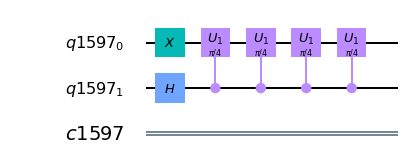

In [ ]:
qc.draw(output='mpl')

Looks good. Now let's apply the final Hadamard gate and measure.

In [ ]:
# Apply Hadamard gate on qubit 1
qc.h(1)

# Measure
qc.measure(1, 0)

# Get measurement results of 1 simulations
backend = Aer.get_backend('qasm_simulator')
job_sim = execute(qc, backend, shots = 1)
sim_result = job_sim.result()
counts = sim_result.get_counts(qc)

measurement_results.append(int(list(counts.keys())[0]))
print(counts)

{'1': 1}


The output is $1$. Based this, we shall build the second circuit. But before we move on to that, we'll take a look at the final circuit.

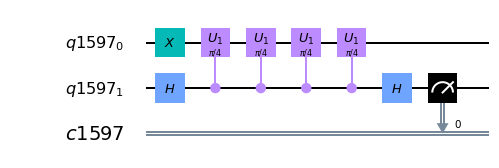

In [ ]:
qc.draw(output='mpl')

Looks good. Since the first circuit resulted in $1$, the second circuit should have the $R_2$ gate. 

In [ ]:
qr = QuantumRegister(2)

# Prepare the classical register
cr = ClassicalRegister(1)

# Prepare the quantum circuit
qc = QuantumCircuit(qr, cr)

# Apply X gate on qubit 0 to prepare the eigenvector
qc.x(0)

# Apply Hadamard gate on qubit 1
qc.h(1)

# Apply controlled rotations controlled on qubit 1
for count in range(2):
  qc.cu1(np.pi/4, 1, 0)

# Apply rotation based on the previous measurement outputs.
qc.u1(-np.pi/2, 1)

# Apply Hadamard gates on qubits 1
qc.h(1)

# Measure
qc.measure(1, 0)

# Get measurement results of 1 simulations
backend = Aer.get_backend('qasm_simulator')
job_sim = execute(qc, backend, shots = 1)
sim_result = job_sim.result()
counts = sim_result.get_counts(qc)

measurement_results.append(int(list(counts.keys())[0]))
print(counts)

{'0': 1}


We see that the output is $0$. Based on the $2$ outputs, we have seen so far, we build the third and final circuit. But before we go, as always, we take a sneak peak at the circuit.

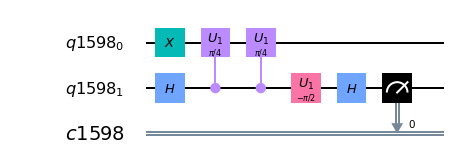

In [ ]:
qc.draw(output = 'mpl')

In [ ]:
# Prepare quantum register
qr = QuantumRegister(2)

# Prepare the classical register
cr = ClassicalRegister(1)

# Prepare the quantum circuit
qc = QuantumCircuit(qr, cr)

# Apply X gate on qubit 0 to prepare the eigenvector
qc.x(0)

# Apply Hadamard gate on qubit 1
qc.h(1)

# Apply controlled rotations controlled on qubit 1
qc.cu1(np.pi/4, 1, 0)

# Apply rotation based on the previous measurement outputs.
qc.u1(-np.pi/4, 1)

# Apply Hadamard gates on qubits 1
qc.h(1)

# Measure
qc.measure(1, 0)

# Get measurement results of 1 simulations
backend = Aer.get_backend('qasm_simulator')
job_sim = execute(qc, backend, shots = 1)
sim_result = job_sim.result()
counts = sim_result.get_counts(qc)

measurement_results.append(int(list(counts.keys())[0]))
print(counts)

{'0': 1}


So, the final bitstring is

In [ ]:
measurement_results.reverse()
measurement_results

[0, 0, 1]

And the final circuit is 

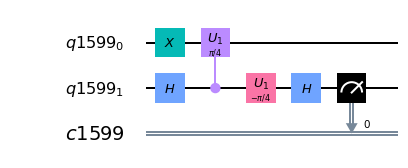

In [ ]:
qc.draw(output = 'mpl')

Now, let's carry out this circuit a $100$ times

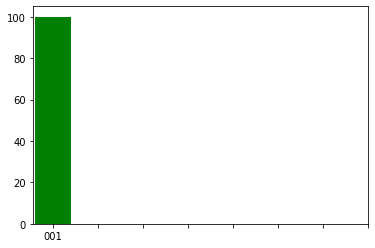

In [ ]:
results = {}
for simulation in range(100):
  # Initialize the measurement list
  measurement_results = []
  for control_qubit in range(3):
    # Prepare quantum register
    qr = QuantumRegister(2)

    # Prepare the classical register
    cr = ClassicalRegister(1)

    # Prepare the quantum circuit
    qc = QuantumCircuit(qr, cr)

    # Apply X gate on qubit 0 to prepare the eigenvector
    qc.x(0)

    # Apply Hadamard gate on qubit 1
    qc.h(1)

    # Apply controlled rotations controlled on qubit 1
    for count in range(2 ** (2-control_qubit)):
      qc.cu1(np.pi/4, 1, 0)

    for k in range(len(measurement_results)):
      if measurement_results[k] == 1:
        qc.u1(-np.pi/(2 ** (len(measurement_results) - k)), 1)

    # Apply Hadamard gates on qubits 1
    qc.h(1)

    # Measure
    qc.measure(1, 0)

    # Get measurement results of 1 simulations
    backend = Aer.get_backend('qasm_simulator')
    job_sim = execute(qc, backend, shots = 1)
    sim_result = job_sim.result()
    counts = sim_result.get_counts(qc)

    measurement_results.append(int(list(counts.keys())[0]))
  measurement_results.reverse()

  # Update the results
  try:
    results[''.join([str(x) for x in measurement_results])] += 1
  except KeyError:
    results[''.join([str(x) for x in measurement_results])] = 1

# Plot the results
plt.bar(results.keys(), results.values(), color='g')
plt.xticks(list(range(8)))
plt.show()

As we can see, the output is always $1$. Now, to the get the value of the phase $\theta$, we simply divide the output by $2^{3} = 8$, which gives us $\frac{1}{8}$, which is the correct answer. 

## When $| \psi \rangle = |0\rangle$

In this section, we shall use our $U$ gate to compute the phase associated with it's eigenvector $|0\rangle$, dynamically Our final circuit will have the form

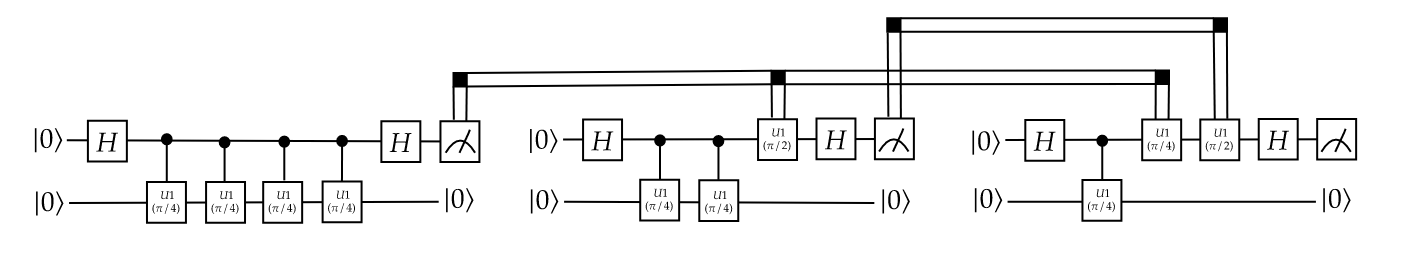

Since constructing and executing the phase estimation circuit for the eigenvector $|1\rangle$ was explained in detail in the previous section, we are not going to explain the circuit for the eigenvector $|0\rangle$'s extensively as it is extremely similar to that of $|1\rangle$, except for the vector preparation part. 

Executing the cell below runs a dynamic quantum circuit for the Quantum Phase Estimation for the unitary $U$ and the eigenvector $|0\rangle$ $100$ times.

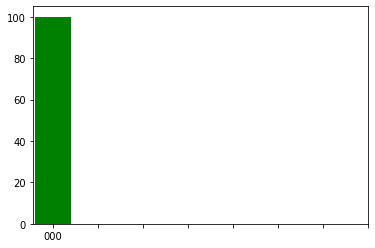

In [ ]:
results = {}
for simulation in range(100):
  # Initialize the measurement list
  measurement_results = []
  for control_qubit in range(3):
    # Prepare quantum register
    qr = QuantumRegister(2)

    # Prepare the classical register
    cr = ClassicalRegister(1)

    # Prepare the quantum circuit
    qc = QuantumCircuit(qr, cr)

    # Apply Hadamard gate on qubit 1
    qc.h(1)

    # Apply controlled rotations 
    for count in range(2 ** (2-control_qubit)):
      qc.cu1(np.pi/4, 1, 0)

    for k in range(len(measurement_results)):
      if measurement_results[k] == 1:
        qc.u1(-np.pi/(2 ** (len(measurement_results) - k)), 1)

    # Apply Hadamard gates on qubits 1
    qc.h(1)

    # Measure
    qc.measure(1, 0)

    # Get measurement results of 1 simulations
    backend = Aer.get_backend('qasm_simulator')
    job_sim = execute(qc, backend, shots = 1)
    sim_result = job_sim.result()
    counts = sim_result.get_counts(qc)

    measurement_results.append(int(list(counts.keys())[0]))
  measurement_results.reverse()

  # Update the results
  try:
    results[''.join([str(x) for x in measurement_results])] += 1
  except KeyError:
    results[''.join([str(x) for x in measurement_results])] = 1

# Plot the results
plt.bar(results.keys(), results.values(), color='g')
plt.xticks(list(range(8)))
plt.show()

As we can see, the output is always $0$, which means that the phase associated with $|0\rangle$ is $0$.

# Case 2

In case of the $T$ gate, since the phase is $\frac{1}{8}$ we always get the exact answer as the output of the phase estimation circuit, if we use $3$ qubits in th first register. We know that in most cases, the output of the phase estimation circuit is an approximation of the phase, rather than the exact answer. Consider the gate

\begin{equation}
  U = 
  \begin{bmatrix}
    1 & 0 \\
    0 & e^{\frac{2 \pi i}{5}}
  \end{bmatrix}
\end{equation}

Since this is also a diagonal matrix, it's eigenvectors are $|0\rangle$ with eigenvalue $1$ and $|1\rangle$ with eigenvalue $e^{\frac{ 2 \pi i}{5}}$. That means, the phase associated with the eigenvector $|1\rangle$ is $\frac{1}{5}$, and the phase associated with the eigenvector $|0\rangle$ is $0$. If we want to carry out phase estimation with this matrix, then we should be able to apply this matrix, as a gate, in a controlled manner, that is, we should be able to use the gate

\begin{equation}
  CU =
  \begin{bmatrix}
    1 & 0 & 0 & 0\\
    0 & 1 & 0 & 0\\
    0 & 0 & 1 & 0\\
    0 & 0 & 0 & e ^ {\frac{2 \pi i}{5}}
  \end{bmatrix}
\end{equation}
 
This, can be done by the $CU1(\phi)$ gate available in Qiskit, whose structure is described in the previous section. 


## When $| \psi \rangle = |0\rangle$

In this case, we start with finding the phase associated with the eigenvector $|0\rangle$. The final circuit will have the form

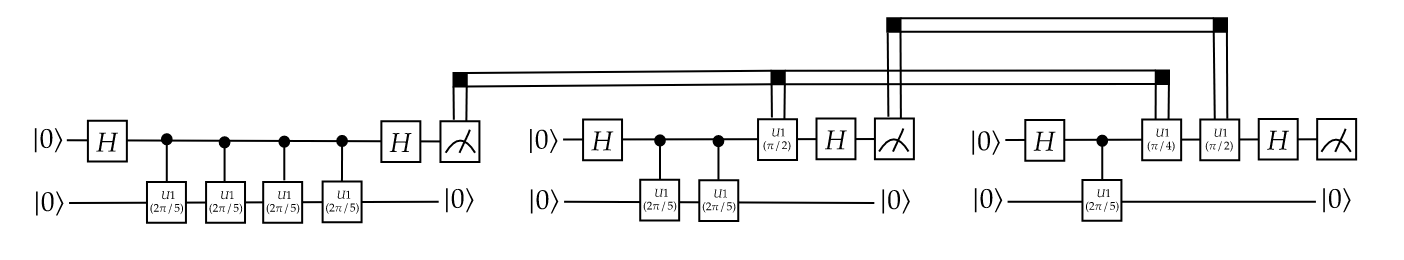

Executing the cell below runs a dynamic quantum circuit for the Quantum Phase Estimation for the unitary $U$ and the eigenvector $|0\rangle$ $100$ times.

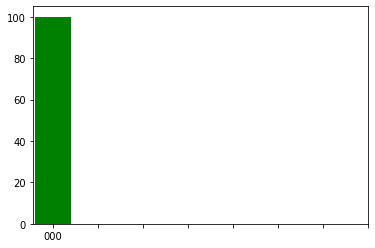

In [ ]:
results = {}
for simulation in range(100):
  # Initialize the measurement list
  measurement_results = []
  for control_qubit in range(3):
    # Prepare quantum register
    qr = QuantumRegister(2)

    # Prepare the classical register
    cr = ClassicalRegister(1)

    # Prepare the quantum circuit
    qc = QuantumCircuit(qr, cr)

    # Apply Hadamard gate on qubit 1
    qc.h(1)

    # Apply controlled rotations controlled on qubit 1
    for count in range(2 ** (2-control_qubit)):
      qc.cu1(2 * np.pi/5, 1, 0)

    for k in range(len(measurement_results)):
      if measurement_results[k] == 1:
        qc.u1(-np.pi/(2 ** (len(measurement_results) - k)), 1)

    # Apply Hadamard gates on qubits 1
    qc.h(1)

    # Measure
    qc.measure(1, 0)

    # Get measurement results of 1 simulations
    backend = Aer.get_backend('qasm_simulator')
    job_sim = execute(qc, backend, shots = 1)
    sim_result = job_sim.result()
    counts = sim_result.get_counts(qc)

    measurement_results.append(int(list(counts.keys())[0]))
  measurement_results.reverse()

  # Update the results
  try:
    results[''.join([str(x) for x in measurement_results])] += 1
  except KeyError:
    results[''.join([str(x) for x in measurement_results])] = 1

# Plot the results
plt.bar(results.keys(), results.values(), color='g')
plt.xticks(list(range(8)))
plt.show()

As we can see, the output is always $0$, which means that the phase associated with $|0\rangle$ is $0$.


## When $| \psi \rangle = |1\rangle$

Now, we shall move on to finding the phase associated with the eigenvector $|1\rangle$. The circuit will then have the form

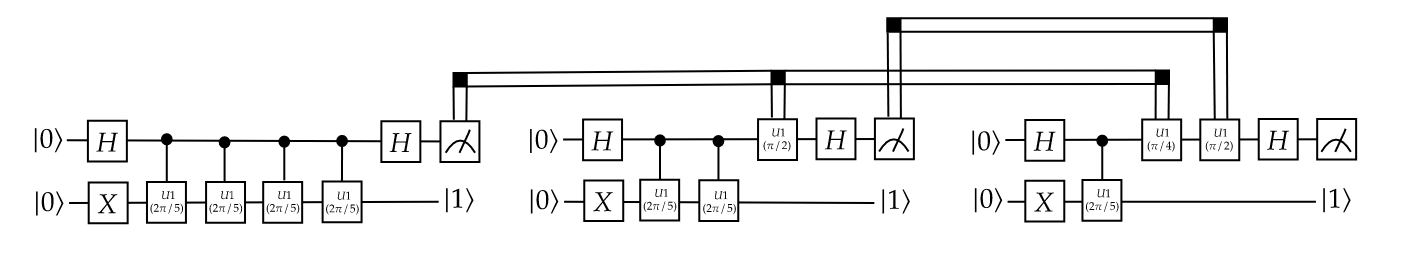

Executing the cell below runs a dynamic quantum circuit for the Quantum Phase Estimation for the unitary $U$ and the eigenvector $|1\rangle$ $100$ times.

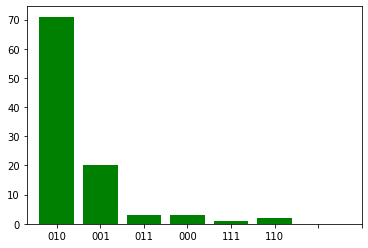

In [ ]:
results = {}
for simulation in range(100):
  # Initialize the measurement list
  measurement_results = []
  for control_qubit in range(3):
    # Prepare quantum register
    qr = QuantumRegister(2)

    # Prepare the classical register
    cr = ClassicalRegister(1)

    # Prepare the quantum circuit
    qc = QuantumCircuit(qr, cr)

    # Apply X gate on qubit 0 to prepare the eigenvector
    qc.x(0)

    # Apply Hadamard gate on qubit 1
    qc.h(1)

    # Apply controlled rotations controlled on qubit 1
    for count in range(2 ** (2-control_qubit)):
      qc.cu1(2 * np.pi/5, 1, 0)

    for k in range(len(measurement_results)):
      if measurement_results[k] == 1:
        qc.u1(-np.pi/(2 ** (len(measurement_results) - k)), 1)

    # Apply Hadamard gates on qubits 1
    qc.h(1)

    # Measure
    qc.measure(1, 0)

    # Get measurement results of 1 simulations
    backend = Aer.get_backend('qasm_simulator')
    job_sim = execute(qc, backend, shots = 1)
    sim_result = job_sim.result()
    counts = sim_result.get_counts(qc)

    measurement_results.append(int(list(counts.keys())[0]))
  measurement_results.reverse()

  # Update the results
  try:
    results[''.join([str(x) for x in measurement_results])] += 1
  except KeyError:
    results[''.join([str(x) for x in measurement_results])] = 1

# Plot the results
plt.bar(results.keys(), results.values(), color='g')
plt.xticks(list(range(8)))
plt.show()

In this case, we see that there have been multiple outcomes as the result of this simulation. The most probable outcome is $2$. That means, the phase associated with $|1\rangle$ is approximately $\frac{2}{2^3} = \frac{1}{4}$. The exact value of the phase is $\frac{1}{5}$. So, the approximation returned by the circuit makes sense.